In [ ]:
from google.colab import output

!git clone https://github.com/pkseniya/EmbeddingComponents.git
!python -m pip install -e ./EmbeddingComponents

!python -m pip install shap datasets
!pip install --upgrade --no-cache-dir gdown
!gdown 1W3eo0VQXxcSjY8kx4IgHGlopd6OK69pp
!unzip probing.zip

!gdown 1PFSpW14aXO-sMNzT_jIjZPfNhk3u3ULD
!unzip probing_numbers.zip

output.clear()

Cloning into 'EmbeddingComponents'...
remote: Enumerating objects: 723, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (23/23), done.


In [ ]:
import gc
import numpy as np
import pickle
import random
from functools import partial
from datasets import load_from_disk
import torch
import torch.nn.functional as F
import shap
import seaborn as sns
import matplotlib.pyplot as plt
try:
  from senteval.tools.validation import SplitClassifier, SplitClassifier2
except (ImportError, KeyError, ModuleNotFoundError):
  print('Stopping RUNTIME. Colaboratory will restart automatically. Please run again.')
  print("REQUIRED RELOADING FOR SENTEVAL")
  exit()
  
SEED = 8
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

Mounted at /content/drive


In [ ]:
MODEL = None
def prepare_embeds(task_embed):
    X = {'train':  np.array(task_embed['train']['X']),
     'valid':  np.array(task_embed['dev']['X']),
     'test':  np.array(task_embed['test']['X'])}
    y = {'train':  np.array(task_embed['train']['y']),
        'valid':  np.array(task_embed['dev']['y']),
        'test':  np.array(task_embed['test']['y'])}
    return X, y


def predict_probas(input_values):
    model = MODEL
    input_values = torch.tensor(input_values, dtype=torch.float).to('cuda')
    out = np.array(F.softmax(model(input_values), dim=1).to('cpu'))
    return out


def get_shap_values(task_name):
    task_embed = load_from_disk("{}.hf".format(task_name))
    labels = sorted(np.unique(task_embed['train']['y']))
    nclasses = len(dict(zip(labels, range(len(labels)))))
    params_classifier = {'nhid': 384, 'optim': 'rmsprop', 'batch_size': 128, 'tenacity': 3, 'epoch_size': 2}
    config_MLP = {'nclasses': nclasses, 'seed': SEED, 'usepytorch': True, 'classifier': params_classifier}
    X, y = prepare_embeds(task_embed)
    clf_MLP = SplitClassifier2(X, y, config=config_MLP)

    if config_MLP['usepytorch']:
        mlp_model = clf_MLP.run().model
        mlp_model.eval()
        global MODEL
        MODEL = mlp_model
        with torch.no_grad():
            explainer_mlp = shap.Explainer(predict_probas,  X['train'], seed=SEED)
            shap_values_mlp = explainer_mlp(shap.sample(X['test'], nsamples=1000, random_state=SEED), max_evals=1800)
    else:
        mlp_model = clf_MLP.run()
        explainer_mlp = shap.Explainer(mlp_model.predict,  X['train'], seed=SEED)
        shap_values_mlp = explainer_mlp(X['test'], max_evals=1800)

    gc.collect()
    return shap_values_mlp

PermutationExplainer explainer: 1001it [28:25,  1.72s/it]


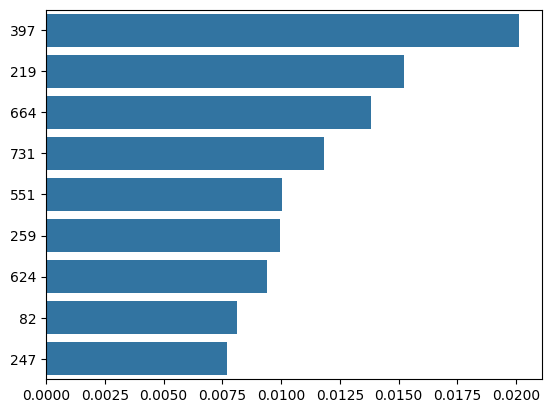

PermutationExplainer explainer: 1001it [28:39,  1.73s/it]


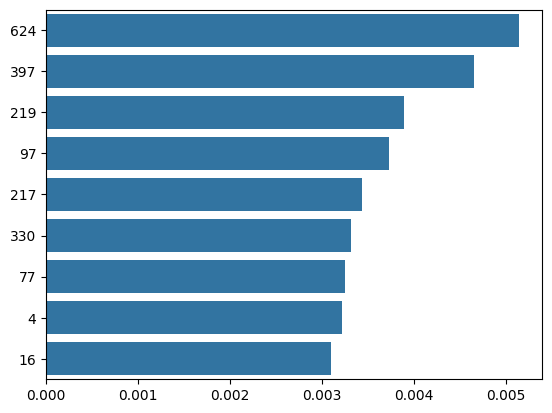

PermutationExplainer explainer: 1001it [28:22,  1.71s/it]


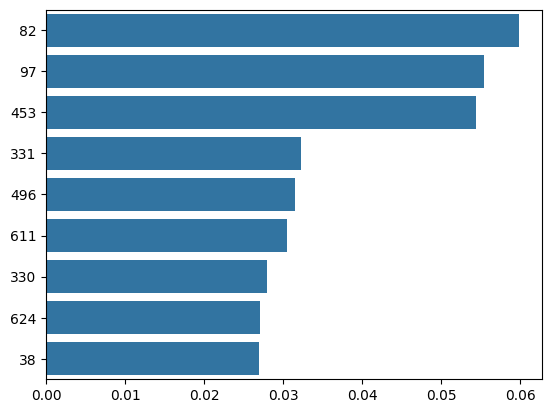

PermutationExplainer explainer: 1001it [27:52,  1.68s/it]


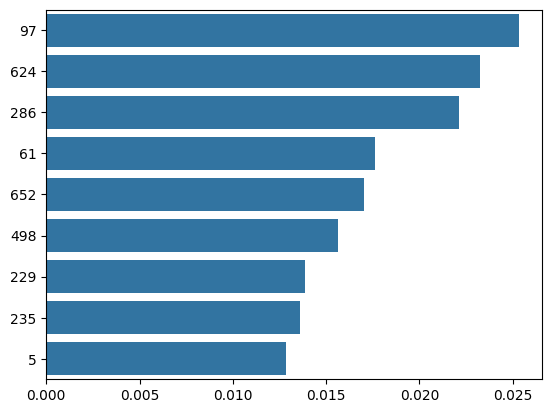

PermutationExplainer explainer: 1001it [27:46,  1.68s/it]


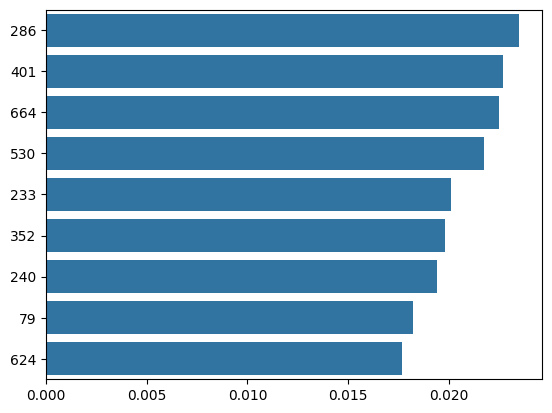

PermutationExplainer explainer: 1001it [27:57,  1.69s/it]


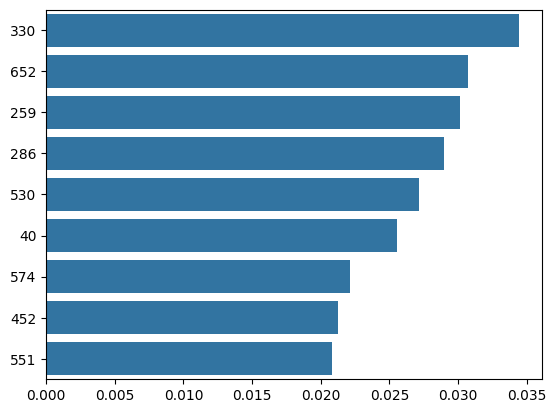

PermutationExplainer explainer: 1001it [28:30,  1.72s/it]


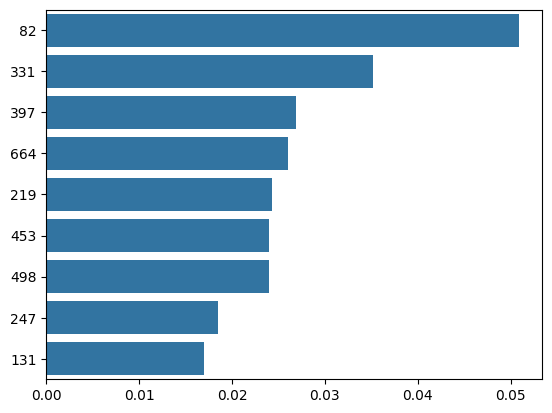

PermutationExplainer explainer: 1001it [28:04,  1.69s/it]


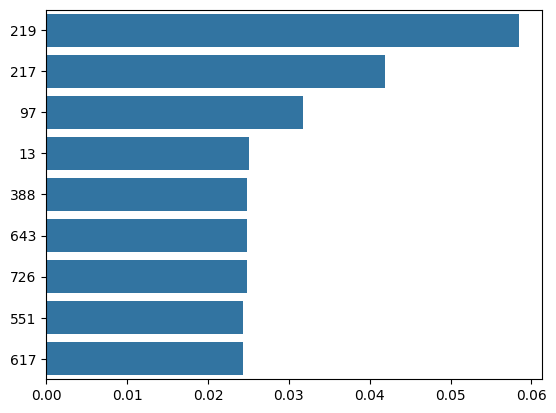

PermutationExplainer explainer: 1001it [57:22,  3.45s/it]


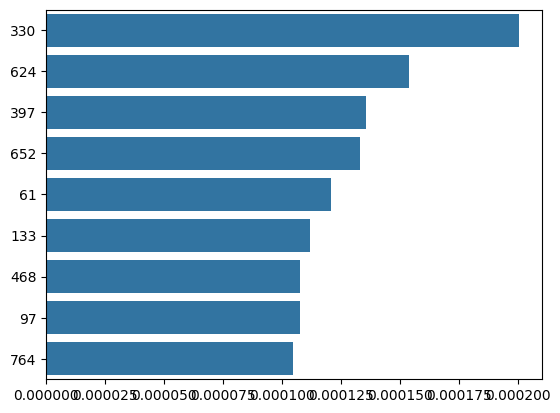

In [ ]:
transfer_tasks = [
    'Length',
    'Depth',
    'TopConstituents',
    'BigramShift',
    'Tense',
    'SubjNumber', 'ObjNumber',
    'OddManOut', 'CoordinationInversion',
    'WordContent',
    ]
shap_values = []
for transfer_task in transfer_tasks:
    for k in range(1):
        shap_values.append(get_shap_values(transfer_task))
        best_names = np.abs(shap_values[-1].values).mean(axis=(0, 2)).argsort()[:-10:-1]
        best_values = np.abs(shap_values[-1].values).mean(axis=(0, 2))[best_names]
        best_names = [str(name) for name in best_names]
        sns.barplot(y=best_names, x=best_values, orient="y")
        plt.show()

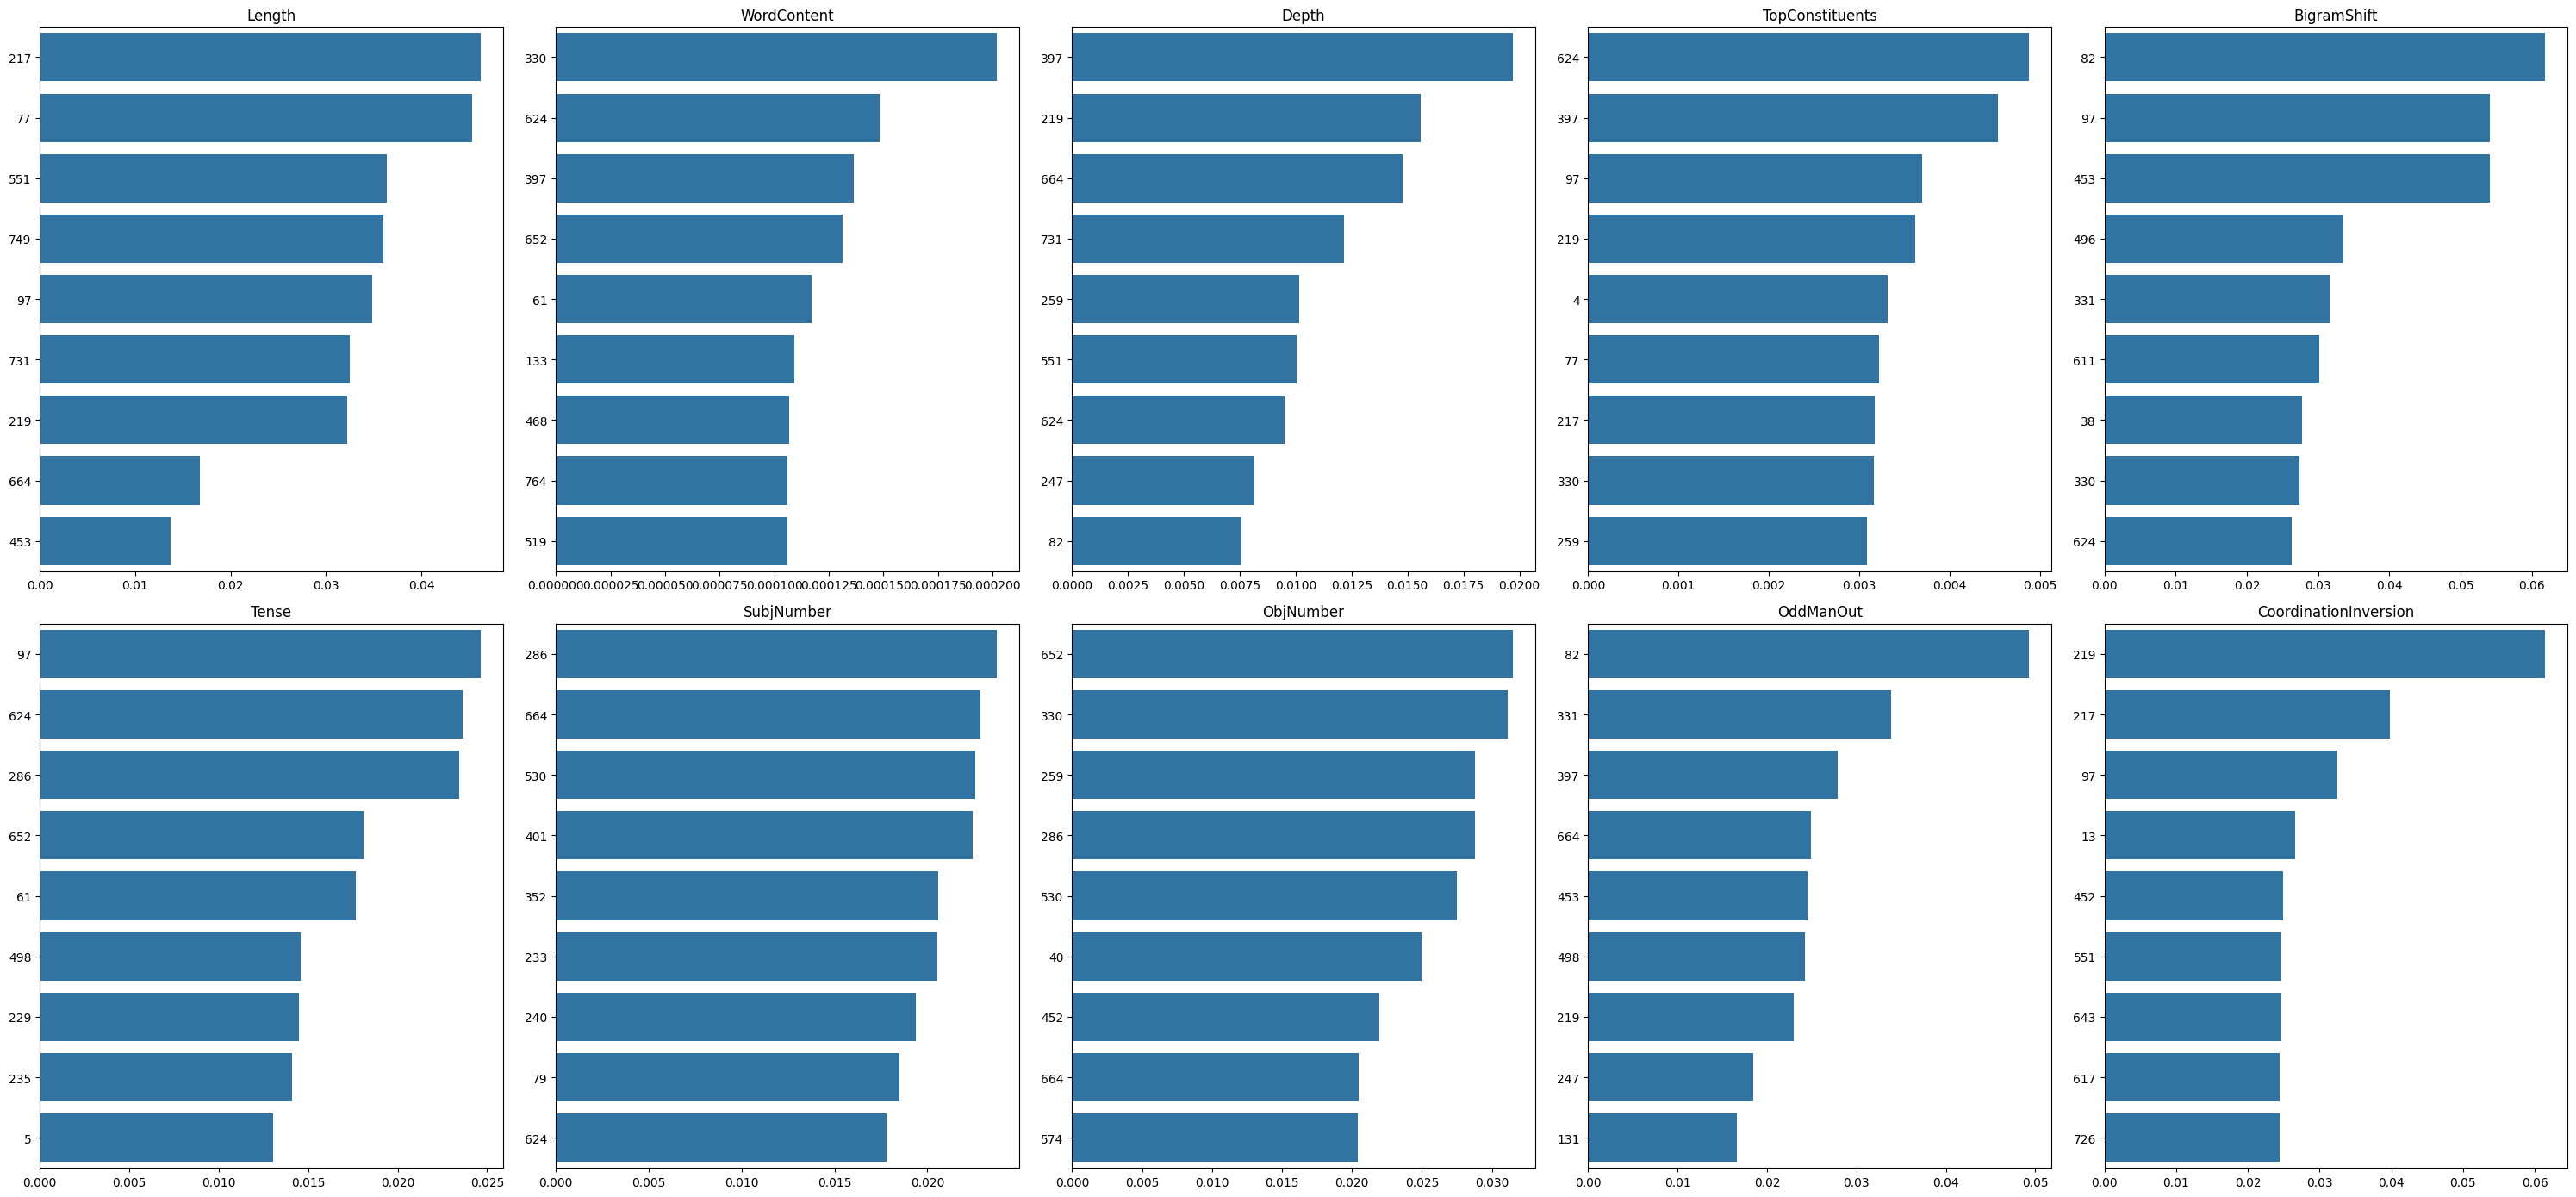

In [ ]:
plt.figure(figsize=(30, 14))
for i, shaps in enumerate(shap_values):
    plt.subplot(2, 5, i + 1)
    best_names = np.abs(shaps.values).mean(axis=(0, 2)).argsort()[:-10:-1]
    best_values = np.abs(shaps.values).mean(axis=(0, 2))[best_names]
    best_names = [str(name) for name in best_names]
    sns.barplot(y=best_names, x=best_values, orient="y")
    plt.title(transfer_tasks[i], )
plt.tight_layout()